<h1>Predict my house listing price using Regression Model on Zillow data</h1>

<body>
    I recently bought a house and I wonder if I list the house for sale right now what should be my listing price. It is a great opportunity to ultilize Machine Learning to predict the listing price.<br>
    Since I am predicting listing price which is a continuous value and there are data of comparable houses I can find on Zillow. I figure this a great opportunity to use Supervised Learning method: <b>Regression</b><br>
    
    
</body>

<h2>Data gathering</h2>
First of all I need to gather data to train the model.<br>
To get a better feel of the data I am looking for. I currently live in a single-family home with 3 bedrooms, 2 bathroom, 1,413 sqrt feet living area, 0.28 arce lot in the 76126 zipcode<br>
I think looking for single family home in the 76126 zipcode from Zillow will be the most representative data set to predict the price of my home.<br>
I am ultilizing the RapidAPI to get data from Zillow


In [1]:
#Import neccessary packages
import pandas as pd #data
import numpy as np
import json
import requests
import time
import copy
import math
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.options.display.max_columns = None # show all columns in display

In [80]:
#Request RapidAPI
url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"


headers = {
	"X-RapidAPI-Key": "SIGN UP FOR KEY",
	"X-RapidAPI-Host": "zillow-com1.p.rapidapi.com"
}

querystring = {"location":"76126", "home_type":"Houses"}
response = requests.request("GET", url, headers=headers, params=querystring)

result_json = json.loads(response.text)
training_set = result_json["props"]
total_result_count = result_json["totalResultCount"]
total_result_pages = result_json["totalPages"]

#If more than 1 page of results get the rest of the data 
if total_result_pages > 1: 
    for page_counter in range(2, total_result_pages+1):
        querystring = {"location":"76126", "page":page_counter, "home_type":"Houses"}
        response = requests.request("GET", url, headers=headers, params=querystring)
        result_json = json.loads(response.text)
        training_set.extend(result_json["props"])
        #wait 1 sec based on limit
        time.sleep(1.5)
        
#convert list to data frame for easy manipulation
df_training_set = pd.json_normalize(data=training_set)

#Save training set to csv for analysis
datetimeNow = time.strftime("%d-%m-%y %H-%M", time.localtime())
df_training_set.to_csv(f"ZillowTrainingSetSingleFamily76126{datetimeNow}.csv") 

5

In [98]:
#Review training set
print(total_result_count)
df_training_set

192


,dateSold,propertyType,lotAreaValue,address,imgSrc,price,bedrooms,longitude,latitude,listingStatus,zpid,contingentListingType,daysOnZillow,bathrooms,livingArea,country,currency,lotAreaUnit,hasImage,listingSubType.is_FSBA,listingSubType.is_openHouse,newConstructionType,listingSubType.is_newHome,unit
0,None,SINGLE_FAMILY,0.269,"1007 Keller Ave, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/113a8a9e7c3...,250000,4,-97.454056,32.672153,FOR_SALE,28931848,None,-1,2,1423,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
1,None,SINGLE_FAMILY,1.200,"8252 Money Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/c0b3c459ba6...,480000,4,-97.548130,32.604034,FOR_SALE,83799755,None,-1,3,2694,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
2,None,SINGLE_FAMILY,10846.440,"5525 La Bandera Trl, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/4aaa23976ec...,424000,4,-97.460200,32.690670,FOR_SALE,79957405,None,-1,2,2423,USA,USD,sqft,True,True,True,NaN,NaN,NaN
3,None,SINGLE_FAMILY,0.680,"4309 Ridgeway Rd, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/d49ce973f13...,548500,3,-97.509470,32.688503,FOR_SALE,29217119,None,-1,2,2546,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
4,None,SINGLE_FAMILY,1.550,"12740 Bella Vino Dr, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/54d42c9b07b...,1100000,5,-97.537410,32.631744,FOR_SALE,118232037,None,-1,4,4016,USA,USD,acres,True,True,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,None,SINGLE_FAMILY,0.000,"10604 Oates Branch Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/69fd43e8224...,599900,4,-97.511380,32.665900,FOR_SALE,2066834545,None,-1,3,2513,USA,USD,sqft,True,NaN,True,BUILDER_SPEC,True,NaN
188,None,SINGLE_FAMILY,NaN,"2603W Plan, Ventana 50'",https://photos.zillowstatic.com/fp/99f7fa528cf...,606900,4,-97.506500,32.670403,FOR_SALE,2062415080,None,-1,4,2603,USA,USD,None,True,NaN,NaN,BUILDER_PLAN,True,# 696SFA
189,None,SINGLE_FAMILY,0.330,"9705 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/0032c7ec036...,1674000,5,NaN,NaN,FOR_SALE,2066546294,None,-1,5,4898,USA,USD,acres,True,NaN,NaN,BUILDER_SPEC,True,NaN
190,None,SINGLE_FAMILY,0.340,"9701 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/aa845e26573...,1674000,5,NaN,NaN,FOR_SALE,2066546235,None,-1,6,4894,USA,USD,acres,True,NaN,NaN,BUILDER_SPEC,True,NaN


<AxesSubplot:>

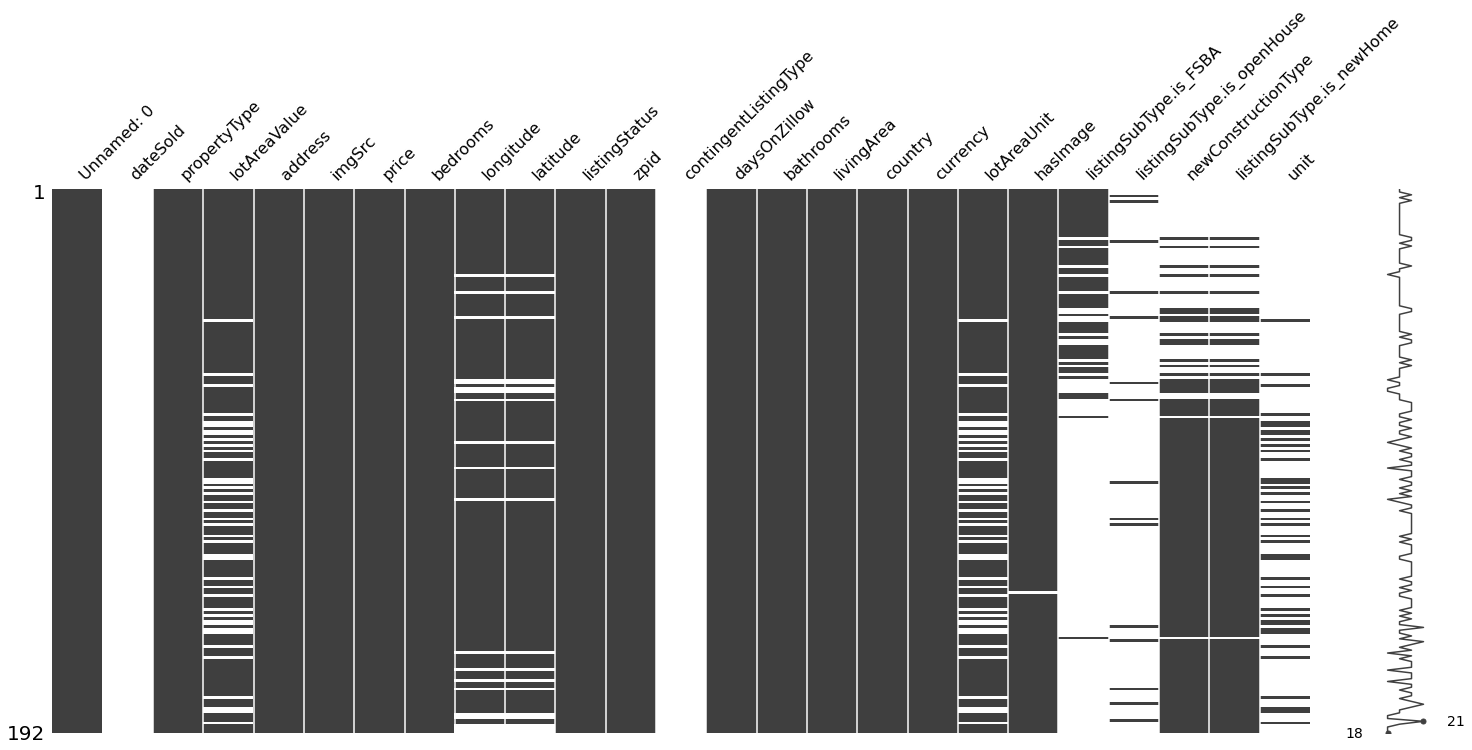

In [2]:
#Reviewing data quality
training_set = pd.read_csv('/Users/anhtran/ZillowTrainingSetSingleFamily28-07-22 17-38.csv')
msno.matrix(training_set)

In [3]:
training_set

,Unnamed: 0,dateSold,propertyType,lotAreaValue,address,imgSrc,price,bedrooms,longitude,latitude,listingStatus,zpid,contingentListingType,daysOnZillow,bathrooms,livingArea,country,currency,lotAreaUnit,hasImage,listingSubType.is_FSBA,listingSubType.is_openHouse,newConstructionType,listingSubType.is_newHome,unit
0,0,NaN,SINGLE_FAMILY,0.269,"1007 Keller Ave, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/113a8a9e7c3...,250000,4,-97.454056,32.672153,FOR_SALE,28931848,NaN,-1,2,1423,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
1,1,NaN,SINGLE_FAMILY,1.200,"8252 Money Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/c0b3c459ba6...,480000,4,-97.548130,32.604034,FOR_SALE,83799755,NaN,-1,3,2694,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
2,2,NaN,SINGLE_FAMILY,10846.440,"5525 La Bandera Trl, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/4aaa23976ec...,424000,4,-97.460200,32.690670,FOR_SALE,79957405,NaN,-1,2,2423,USA,USD,sqft,True,True,True,NaN,NaN,NaN
3,3,NaN,SINGLE_FAMILY,0.680,"4309 Ridgeway Rd, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/d49ce973f13...,548500,3,-97.509470,32.688503,FOR_SALE,29217119,NaN,-1,2,2546,USA,USD,acres,True,True,NaN,NaN,NaN,NaN
4,4,NaN,SINGLE_FAMILY,1.550,"12740 Bella Vino Dr, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/54d42c9b07b...,1100000,5,-97.537410,32.631744,FOR_SALE,118232037,NaN,-1,4,4016,USA,USD,acres,True,True,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,187,NaN,SINGLE_FAMILY,0.000,"10604 Oates Branch Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/69fd43e8224...,599900,4,-97.511380,32.665900,FOR_SALE,2066834545,NaN,-1,3,2513,USA,USD,sqft,True,NaN,True,BUILDER_SPEC,True,NaN
188,188,NaN,SINGLE_FAMILY,NaN,"2603W Plan, Ventana 50'",https://photos.zillowstatic.com/fp/99f7fa528cf...,606900,4,-97.506500,32.670403,FOR_SALE,2062415080,NaN,-1,4,2603,USA,USD,NaN,True,NaN,NaN,BUILDER_PLAN,True,# 696SFA
189,189,NaN,SINGLE_FAMILY,0.330,"9705 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/0032c7ec036...,1674000,5,NaN,NaN,FOR_SALE,2066546294,NaN,-1,5,4898,USA,USD,acres,True,NaN,NaN,BUILDER_SPEC,True,NaN
190,190,NaN,SINGLE_FAMILY,0.340,"9701 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/aa845e26573...,1674000,5,NaN,NaN,FOR_SALE,2066546235,NaN,-1,6,4894,USA,USD,acres,True,NaN,NaN,BUILDER_SPEC,True,NaN


<h2>Data Cleansing</h2>
The following columns need to be cleansed:
<ul>
    <li>lotAreaValue: We have 49 properties with null or 0 as lotAreaValue they represent 25% of the training set so I will preserve these training example by replacing them with median value; The value will also need to be convert to acres because the data set now show data in sqrt ft and arce.</li>
    <li>listingSubType.is_newHome: I will need to convert all blanks to 0 and True to 1 before inputing them to the model.</li>
</ul>



In [4]:
#convert sqft to acre
training_set['lotAreaValue'] = np.where(training_set['lotAreaUnit'] == 'sqft',
                                           training_set['lotAreaValue'] / 43560,
                                           training_set['lotAreaValue'])
training_set['lotAreaUnit'] = "arces"

#fill blank of lotAreaValue with its mean
meanLotArea = training_set['lotAreaValue'].mean() 
print(meanLotArea)
training_set['lotAreaValue'].fillna(value=meanLotArea, inplace=True)

0.592701017903336


In [5]:
#Clean the listingSubType.is_newHome to Integers:
training_set['listingSubType.is_newHome'] = np.where(training_set['listingSubType.is_newHome'] == True, 1, 0)
training_set


,Unnamed: 0,dateSold,propertyType,lotAreaValue,address,imgSrc,price,bedrooms,longitude,latitude,listingStatus,zpid,contingentListingType,daysOnZillow,bathrooms,livingArea,country,currency,lotAreaUnit,hasImage,listingSubType.is_FSBA,listingSubType.is_openHouse,newConstructionType,listingSubType.is_newHome,unit
0,0,NaN,SINGLE_FAMILY,0.269000,"1007 Keller Ave, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/113a8a9e7c3...,250000,4,-97.454056,32.672153,FOR_SALE,28931848,NaN,-1,2,1423,USA,USD,arces,True,True,NaN,NaN,0,NaN
1,1,NaN,SINGLE_FAMILY,1.200000,"8252 Money Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/c0b3c459ba6...,480000,4,-97.548130,32.604034,FOR_SALE,83799755,NaN,-1,3,2694,USA,USD,arces,True,True,NaN,NaN,0,NaN
2,2,NaN,SINGLE_FAMILY,0.249000,"5525 La Bandera Trl, Benbrook, TX 76126",https://photos.zillowstatic.com/fp/4aaa23976ec...,424000,4,-97.460200,32.690670,FOR_SALE,79957405,NaN,-1,2,2423,USA,USD,arces,True,True,True,NaN,0,NaN
3,3,NaN,SINGLE_FAMILY,0.680000,"4309 Ridgeway Rd, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/d49ce973f13...,548500,3,-97.509470,32.688503,FOR_SALE,29217119,NaN,-1,2,2546,USA,USD,arces,True,True,NaN,NaN,0,NaN
4,4,NaN,SINGLE_FAMILY,1.550000,"12740 Bella Vino Dr, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/54d42c9b07b...,1100000,5,-97.537410,32.631744,FOR_SALE,118232037,NaN,-1,4,4016,USA,USD,arces,True,True,True,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,187,NaN,SINGLE_FAMILY,0.000000,"10604 Oates Branch Ln, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/69fd43e8224...,599900,4,-97.511380,32.665900,FOR_SALE,2066834545,NaN,-1,3,2513,USA,USD,arces,True,NaN,True,BUILDER_SPEC,1,NaN
188,188,NaN,SINGLE_FAMILY,0.592701,"2603W Plan, Ventana 50'",https://photos.zillowstatic.com/fp/99f7fa528cf...,606900,4,-97.506500,32.670403,FOR_SALE,2062415080,NaN,-1,4,2603,USA,USD,arces,True,NaN,NaN,BUILDER_PLAN,1,# 696SFA
189,189,NaN,SINGLE_FAMILY,0.330000,"9705 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/0032c7ec036...,1674000,5,NaN,NaN,FOR_SALE,2066546294,NaN,-1,5,4898,USA,USD,arces,True,NaN,NaN,BUILDER_SPEC,1,NaN
190,190,NaN,SINGLE_FAMILY,0.340000,"9701 Saint Michel Ct, Fort Worth, TX 76126",https://photos.zillowstatic.com/fp/aa845e26573...,1674000,5,NaN,NaN,FOR_SALE,2066546235,NaN,-1,6,4894,USA,USD,arces,True,NaN,NaN,BUILDER_SPEC,1,NaN


<h2>Feature selection</h2>

Out of all the available features from Zillow API. I decide to use the follow features to predict price:
<ul>
    <li>lotAreaValue: area of the lot property sits on</li>
    <li>bedrooms: numbers of bedrooms</li>
    <li>bathrooms: numbers of bathroom</li>
    <li>livingArea: square footage of property's living area</li>
    <li>listingSubType.is_newHome: indicate if the property is new constrution </li>
</ul>

In [7]:
#Feature selection
X_train = training_set[['lotAreaValue','bedrooms','bathrooms','livingArea','listingSubType.is_newHome']]
y_train = training_set['price']


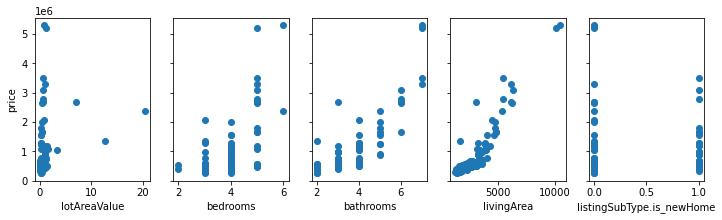

In [8]:
#Plot training data
fig,ax=plt.subplots(1, 5, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train.iloc[:,[i]],y_train)
    ax[i].set_xlabel(X_train.columns[i])
ax[0].set_ylabel("price")
plt.show()

<h2>Running Gradient Descent</h2>

The necessary functions to run Gradient descent are below

In [9]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

Run initial descent. I set the algorithm run 10000 iterations with alpha of 1.0e-8

In [10]:
# initialize parameters
initial_w = np.array([0., 0., 0.,0.,0.])
initial_b = 0.
# some gradient descent settings
iterations = 100000
alpha = 1.0e-8
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train.to_numpy(), y_train, initial_w, initial_b,
                                                     compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
#m,_ = X_train.shape
#for i in range(m):
#    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 459896166828.10   
Iteration 10000: Cost 87862054259.82   
Iteration 20000: Cost 87840904414.04   
Iteration 30000: Cost 87819763799.30   
Iteration 40000: Cost 87798632411.41   
Iteration 50000: Cost 87777510246.22   
Iteration 60000: Cost 87756397299.54   
Iteration 70000: Cost 87735293567.21   
Iteration 80000: Cost 87714199045.07   
Iteration 90000: Cost 87693113728.94   
b,w found by gradient descent: -120.63,[ 171.78662966 -369.80558163 -119.78499836  312.44486624 -125.04696318] 


<h2>Evaluate the Algorithm result</h2>
I want to visualize the cost to evaluate the algorithm's result. The cost reduced through the iteration and stay relatively flat. The code seems to function properly and alpha (learning rate) seems to be appropriate

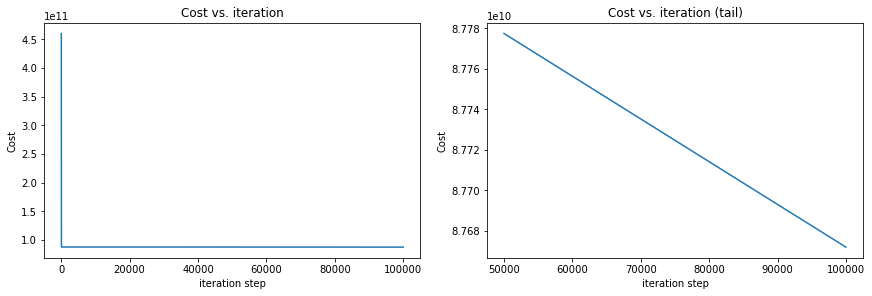

In [16]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(50000 + np.arange(len(J_hist[50000:])), J_hist[50000:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

When comparing the model prediction and target. they seems to provide a decent fit 

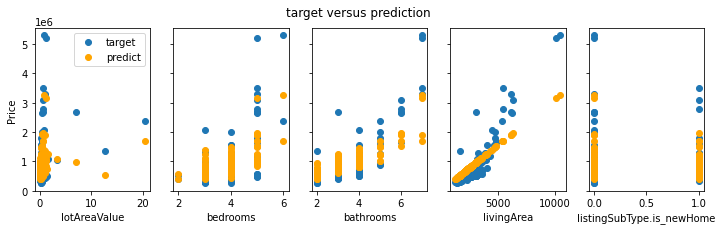

In [17]:
# plot predictions and targets vs original features  
y_pred = np.dot(X_train, w_final) + b_final 

fig,ax=plt.subplots(1,5,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train.iloc[:,[i]],y_train, label = 'target')
    ax[i].set_xlabel(X_train.columns[i])
    ax[i].scatter(X_train.iloc[:,[i]],y_pred,color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction")
plt.show()

<b>Let's plug in my house stats into the model result and see what is the model prediction

In [15]:
x_house = np.array([0.28, 3, 2, 1413,0])
x_house_predict = np.dot(x_house, w_final) + b_final
print(f" predicted price of a house with 0.28 arce lot, 1413 sqft living area, 3 bedrooms, 2 baths, not new construction = ${x_house_predict}")

 predicted price of a house with 0.28 arce lot, 1413 sqft living area, 3 bedrooms, 2 baths, not new construction = $440063.07524180907


The result this model give a prediction about 440,000. I would be ecstatic I can list my house for this price since I bought the house for 270,000 about 6 months ago. I know housing price has increased since then but a 63% increase is not very realistic. Lets see if feature scaling might help with our model.
<br>
<b>Re-run model with Z-score normalization</b>

In [ ]:
#Z-score normalization function
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

In [102]:
#Scale features
X_train_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
#X_train_norm["newHome"] = X_train["listingSubType.is_newHome"]
X_train_norm

,lotAreaValue,bedrooms,bathrooms,livingArea,listingSubType.is_newHome
0,-1.810675e-01,0.291736,-1.020940,-1.115607,-1.558387
1,3.397027e-01,0.291736,-0.100656,-0.079743,-1.558387
2,-1.922548e-01,0.291736,-1.020940,-0.300608,-1.558387
3,4.883213e-02,-1.144503,-1.020940,-0.200363,-1.558387
4,5.354810e-01,1.727975,0.819628,0.997687,-1.558387
...,...,...,...,...,...
187,-3.315371e-01,0.291736,-0.100656,-0.227258,0.641689
188,-1.863065e-16,0.291736,0.819628,-0.153908,0.641689
189,-1.469462e-01,1.727975,1.739912,1.716517,0.641689
190,-1.413525e-01,1.727975,2.660196,1.713257,0.641689


In [97]:
# initialize parameters
initial_w = np.array([0., 0., 0.,0.,0.])
initial_b = 0.
# some gradient descent settings
iterations = 10000
alpha = 1.0e-3
# run gradient descent 
w_norm, b_norm, J_hist_norm = gradient_descent(X_train_norm.to_numpy(), y_train, initial_w, initial_b,
                                                     compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
#m,_ = X_train.shape
#for i in range(m):
#    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 538578504946.61   
Iteration 1000: Cost 95590706482.95   
Iteration 2000: Cost 53179743902.84   
Iteration 3000: Cost 44213225863.77   
Iteration 4000: Cost 40982311172.44   
Iteration 5000: Cost 39264625790.04   
Iteration 6000: Cost 38175048135.34   
Iteration 7000: Cost 37428385329.63   
Iteration 8000: Cost 36894671479.87   
Iteration 9000: Cost 36502889078.31   
b,w found by gradient descent: 749764.59,[ 107651.43763457 -103235.82715265  130313.61456775  579129.32991974
  -12430.42347936] 


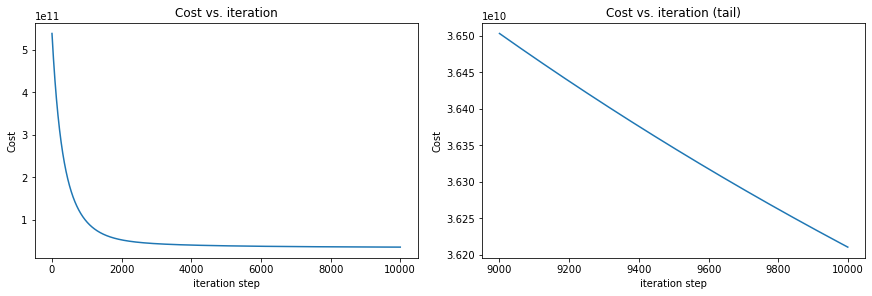

In [98]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist_norm)
ax2.plot(9000 + np.arange(len(J_hist[9000:])), J_hist[9000:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

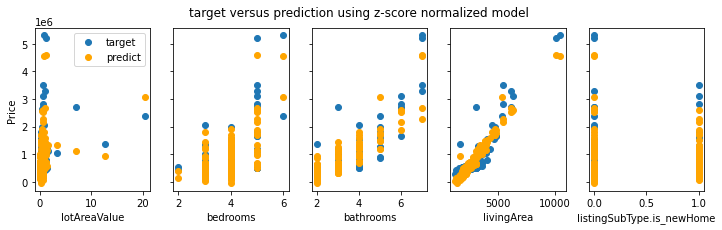

In [99]:
# plot predictions and targets vs original features  
y_pred = np.dot(X_train_norm, w_norm) + b_norm 

fig,ax=plt.subplots(1,5,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train.iloc[:,[i]],y_train, label = 'target')
    ax[i].set_xlabel(X_train.columns[i])
    ax[i].scatter(X_train.iloc[:,[i]],y_pred,color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [100]:
# First, normalize out example.
x_house = np.array([0.28,3, 2, 1413,0])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + norm
print(f" predicted price of a house with 0.28 arce lot, 1413 sqft living area, 3 bedrooms, 2 baths, not new construction = ${x_house_predict}")

lotAreaValue                -0.174914
bedrooms                    -1.144503
bathrooms                   -1.020940
livingArea                  -1.123757
listingSubType.is_newHome   -1.558387
dtype: float64
 predicted price of a house with 0.28 arce lot, 1413 sqft living area, 3 bedrooms, 2 baths, not new construction = $84616.69778371346


The new model give a prediction of about 84000 which is way too low for a house with this specification. It is surprising that feature scaling does not improve this model

<h2>Ideas for model improvement</h2>
There are many factors i think that can improve the accuracy of the model:
<ul>
    <li>Higher data quality: the model might perform better if I can get the lot area without 0 and blanks</li>
    <li>Having more features: important features that affect house prices like age of the house, floor, school district ranking, time since renovation can improve the model quality</li>
</ul>
What are some other suggestions that you think can improve this model. Please message me on LinkedIn! https://www.linkedin.com/in/adrianttran/